# Exploratory Data Analysis (EDA)

For interactive plot of this notebook, please use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels as sm

In [2]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# stationary
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import ks_2samp
# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# for interactive plot
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, HTML 

# widget env detector
def is_widget_env(): 
    try: 
        widgets.IntSlider() 
        return True 
    except: 
        return False

In [4]:
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Load and Feature Computation

In [5]:
time_df = yf.download('MSFT', start="2025-01-01", auto_adjust=True)
time_df.columns = [col[0] for col in time_df.columns]
time_df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,415.514832,422.950005,411.812165,422.413951,16896500
2025-01-03,420.249908,420.924922,416.467811,417.996512,16662900
2025-01-06,424.716919,431.139541,422.364279,424.865814,20573600
2025-01-07,419.277100,427.496466,417.718589,425.858555,18139100
2025-01-08,421.451050,423.843406,418.453175,420.359099,15054600


In [6]:
time_df['Return'] = time_df['Close'].pct_change()
time_df['LogReturn'] = np.log(time_df['Close']).diff() / np.log(time_df['Close'].shift(1))
time_df.describe()

,Close,High,Low,Open,Volume,Return,LogReturn
count,275.000000,275.000000,275.000000,275.000000,2.750000e+02,274.000000,274.000000
mean,462.006640,465.954226,457.786618,462.080708,2.363917e+07,0.000011,-0.000018
std,49.381287,49.209839,49.977276,49.905301,1.160319e+07,0.016742,0.002764
min,352.669403,362.536482,342.951498,349.009021,5.855900e+06,-0.099931,-0.017044
25%,414.852417,421.262432,411.841919,417.028664,1.679275e+07,-0.007580,-0.001226
50%,477.179993,479.820007,472.417724,476.320007,2.095870e+07,0.000609,0.000100
75%,505.768387,509.132766,501.626146,504.953259,2.569410e+07,0.006425,0.001034
max,541.057373,553.502444,539.759814,553.283183,1.288553e+08,0.101337,0.016456


## General Data Exploration

### Diagnose date gaps

In [7]:
time_df.index.diff().value_counts().head()

Date
1 days    212
3 days     50
4 days      7
2 days      5
Name: count, dtype: int64

In [8]:
# df for gap vs jump relation
analysis_df = time_df.copy()
analysis_df['GapDays'] = analysis_df.index.to_series().diff().dt.days
analysis_df['AbsJumpInClose'] = analysis_df['Close'].diff().abs()
analysis_df = analysis_df.dropna()

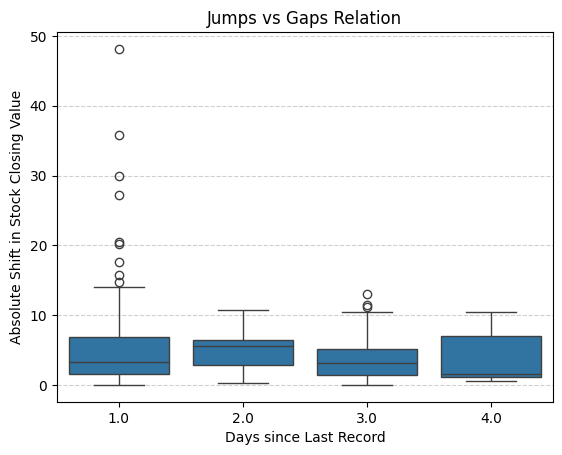

In [9]:
sns.boxplot(data=analysis_df, x = 'GapDays', y = 'AbsJumpInClose')
plt.title('Jumps vs Gaps Relation')
plt.xlabel('Days since Last Record')
plt.ylabel('Absolute Shift in Stock Closing Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [10]:
analysis_df.groupby('GapDays')['AbsJumpInClose'].describe()

,count,mean,std,min,25%,50%,75%,max
GapDays,,,,,,,,
1.0,212.0,5.098740,5.885398,0.019958,1.634926,3.235001,6.868683,48.130005
2.0,5.0,5.179785,3.918209,0.309998,2.830017,5.568909,6.510010,10.679993
3.0,50.0,3.939966,3.389846,0.010010,1.499733,3.109146,5.098480,13.079865
4.0,7.0,4.119629,4.062471,0.526123,1.158615,1.567078,6.976898,10.473175


* The longer gaps (more than 1 day) doesn't affect the jumps, suggesting no abnormality in stock data.

* The consecutive days have higher volatility and are more concerning.

### Distribution

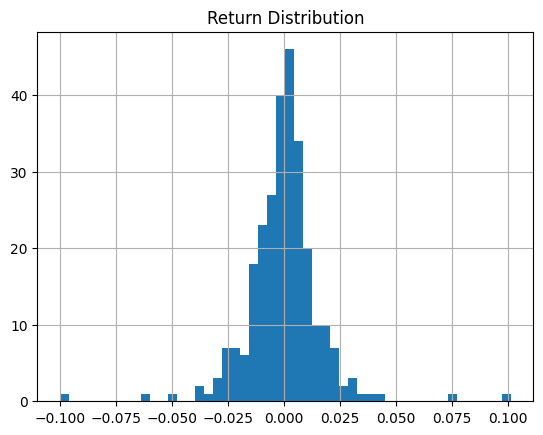

In [11]:
time_df["Return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()

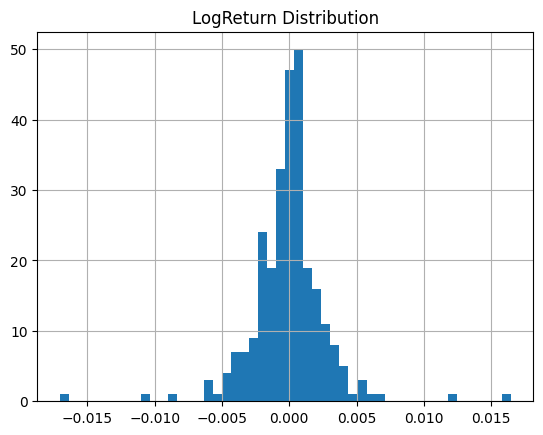

In [12]:
time_df["LogReturn"].hist(bins=50)
plt.title("LogReturn Distribution")
plt.show()

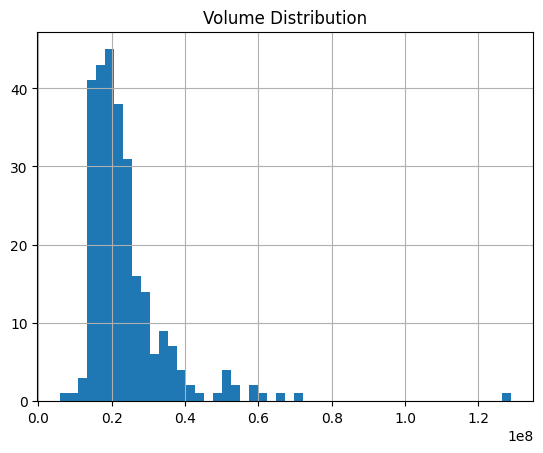

In [13]:
time_df['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.show()

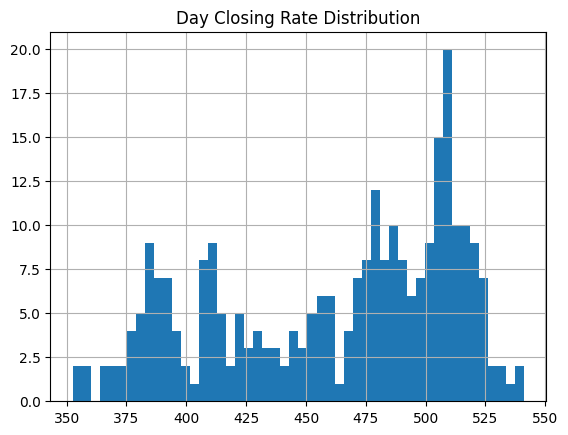

In [14]:
time_df['Close'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

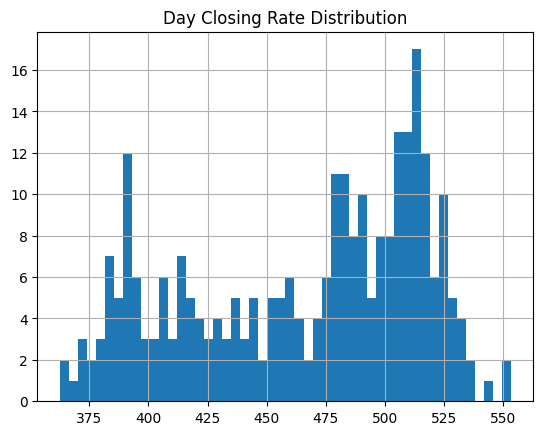

In [15]:
time_df['High'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

* Stock open and close price show multimodal distribution.
  * Tree-based (XGBoost, Random Forest) and Hidden Markov Model might work better than ARIMA or LSTM that work on sequencial data, or could be effect of trend.
  * Feature Engineering may benefit in sequencial based models
* Return and log of retun show normal distribution, better for modeling even ML and DL models
* Volume shows positively skewed distribution

## Exploration Relevant to Forecast

### Decomposition


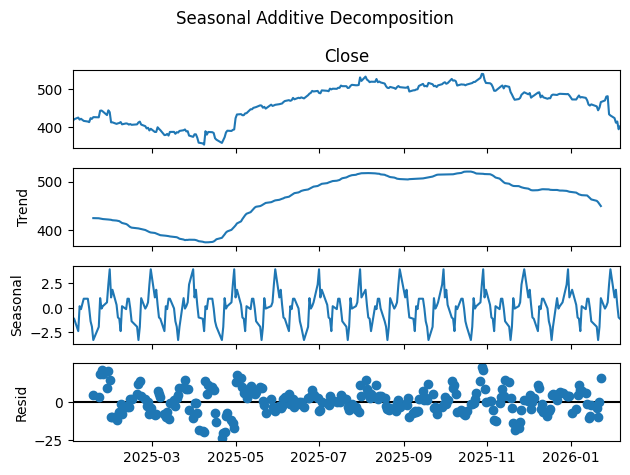

In [16]:
decomp = seasonal_decompose(time_df['Close'], model='additive', period=21)
decomp.plot()
plt.suptitle('Seasonal Additive Decomposition')
plt.tight_layout()
plt.show()

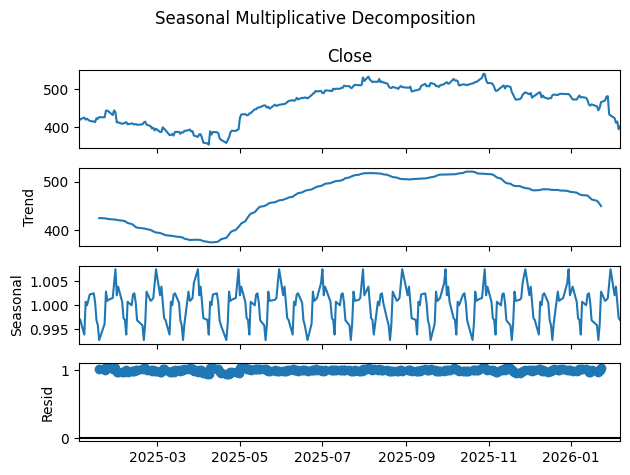

In [17]:
decomp = seasonal_decompose(time_df['Close'], model='multiplicative', period=21)
decomp.plot()
plt.suptitle('Seasonal Multiplicative Decomposition')
plt.tight_layout()
plt.show()

In [18]:
decomp.resid.describe()

count    255.000000
mean       1.000413
std        0.018607
min        0.937665
25%        0.989941
50%        1.000474
75%        1.010879
max        1.048207
Name: resid, dtype: float64

* additive decomposition has uncaptured information (functionation of ±20 in residual)
* multiplicative decomposition has small seasonal component (~1 unit in values of 350-500 units) can be forced and weak/unhelpful.

Requires further seasonality validation, will be done by ACF/PACF.

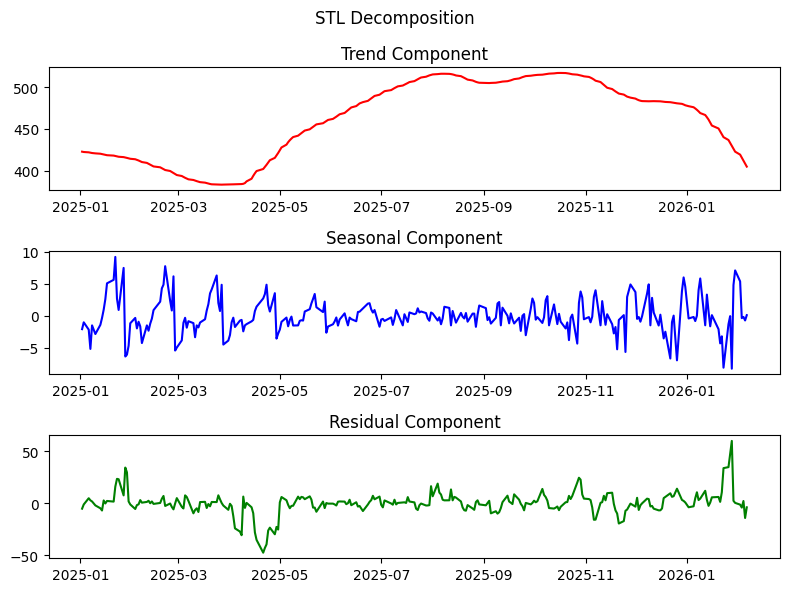

In [19]:
# additive decomposition is stl - offers freedom to seasonal component
stl = STL(time_df['Close'], period=21, seasonal=101, robust=True)
result = stl.fit()

# Plot the decomposition
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
ax1.plot(result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(result.resid, label='Residual', color='green')
ax3.set_title('Residual Component')
plt.suptitle('STL Decomposition')
plt.tight_layout()
plt.show()

In [20]:
def plot_stl(period, seasonal):
    stl = STL(time_df['Close'], period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle(f'STL Decomposition on Close: Period: {period}, Seasona: {seasonal}')
    plt.tight_layout()
    plt.show()

# Slider from 3 to 71
if is_widget_env():
    interact(plot_stl, 
            period=widgets.IntSlider(min=3, max=71, step=1, value=25),
            seasonal=widgets.IntSlider(min=7, max=151, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl(period=25, seasonal=21)
    display(HTML("<i>showing static plot - use binder 👇 to access interactive plot widget</i>"))

interactive(children=(IntSlider(value=25, description='period', max=71, min=3), IntSlider(value=21, descriptio…

For interactive plot of this notebook, please use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

In [21]:
# multiplicative stl decomposition -
# as data has curve in trend, multiplicative decomposition might better
def plot_mstl(period, seasonal):
    stl = STL(np.log(time_df['Close']), period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle(f'STL Decomposition on Log(Close): Period: {period}, Seasona: {seasonal}')
    plt.tight_layout()
    plt.show()

# Slider from 3 to 71
if is_widget_env():
    interact(plot_mstl, 
            period=widgets.IntSlider(min=3, max=71, step=1, value=25),
            seasonal=widgets.IntSlider(min=3, max=151, step=2, value=21)
    );
else:
    # GitHub fallback: render a static example 
    plot_stl(period=25, seasonal=21)
    display(HTML("<i>showing static plot - use binder 👇 to access interactive plot widget</i>"))

interactive(children=(IntSlider(value=25, description='period', max=71, min=3), IntSlider(value=21, descriptio…

For interactive plot of this notebook, please use [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/shashankgarewal/Time-Series-Analysis-Forecasting/HEAD?filepath=notebooks/02_eda_analysis.ipynb)

* The stl decomposition of series and log-series shows much weaker seasonality, than classic decomposition, indicates weak seasonal comp in series.
* Log decomp didn't improved the residual or seasonality; suggesting series behaves almost additively and **neglible multiplicative effect**.
* The residual component **dominates the comp** and exhibits spikes and **volatility**, is not a white noise; and imply irregular fluctuation drives the series more than any stable periodic pattern.
* ACF, PACF needed here also for checking further dependence and pattern.

[domain-info] some noises in stock data is normal, comes from daily news, events.

### Stationarity Check
Model performs better if data has stationarity, some even assumes stationary data

raw Close price is already non-stationary (has trend). 

Check will be performed on Log Return, as log may not cause vanishing exploding gradient problem in model.

Log return provide some meaning benefits over other transformation (return) like; during forecast there will be no intermediate price dependence, addition instead of multiply during reconstruction of Close price.

In [22]:
# weak stationary test

## augmented dickey fuller - diff based
## null hypothesis; non-stationary (series has root unit)
def get_adfuller(series, name=""):
    adf_result = adfuller(series.dropna())
    print(f"adfuller test on {name}: {name} stationary if p < 0.05 | stat < critical values\n")
    adf_result = adfuller(time_df['Return'].dropna())

    print("p-value:", adf_result[1])
    print("adf stat:", adf_result[0])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'{key}: {round(value, 3)}')

## kpss test
## null hypothesis: stationary series     
def get_kpss(series, literal='ct', name=""):
    kpss_result = kpss(series.dropna(), literal)
    print(f"kpss test on {name}: {name} stationary if p > 0.05 | stat > critical values\n")
    print("p-value:", kpss_result[1])
    print("adf stat:", kpss_result[0])
    print('Critical Values for Return:')
    for key, value in kpss_result[3].items():
      print(f'{key}: {round(value, 3)}')

In [23]:
get_adfuller(time_df['LogReturn'], "log return")

adfuller test on log return: log return stationary if p < 0.05 | stat < critical values

p-value: 2.2910771130006227e-29
adf stat: -16.469302033406674
Critical Values:
1%: -3.455
5%: -2.872
10%: -2.572


In [24]:
get_kpss(time_df['LogReturn'], "ct", "log return")

kpss test on log return: log return stationary if p > 0.05 | stat > critical values

p-value: 0.04633386502971585
adf stat: 0.15039936196434098
Critical Values for Return:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


In [25]:
# join distribution test for strict stationarity
## ks test
## null hyphothesis: stationary
def get_ks(series, name=""):
    print(f"ks test on {name}: stationary if p > 0.05\n")
    split = len(series.dropna()) // 2
    stat, pvalue = ks_2samp(series.dropna()[0:split],
                            series.dropna()[split:-1])
    print(f"KS Statistic: {stat:.4f}")
    print(f"P-value: {pvalue:.4f}")

In [26]:
get_ks(time_df['LogReturn'], 'log-return')

ks test on log-return: stationary if p > 0.05

KS Statistic: 0.0862
P-value: 0.6361


Log-Return Stationarity Check:
* ADF: both p and stat << 0.05; meaning the constant mean. reject non-stationarity.
* KPSS: p is slightly < 0.05, and the stat > the 5% critical value; meaning variance isn't constant. The voltility (as appeared in residual comp) or autocorrelation might be triggering the rejection.
* KS: p > 0.05; series has no difference in join distribution. series is stationary.

Conclusion: The LogReturn series is sufficiently stationary and distributionally stable.

### Autocorrelation
correlation of the feature with its own past values

#### Close price statistics reverify

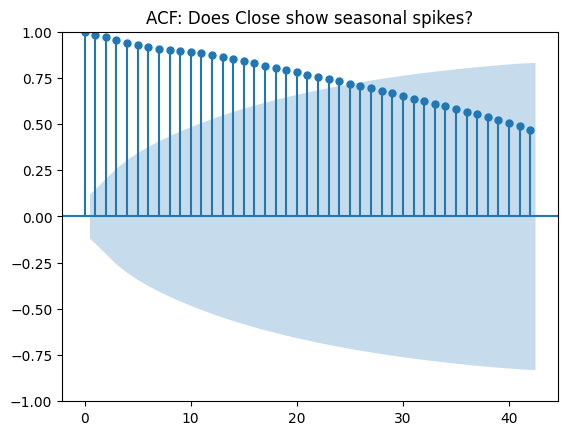

In [27]:
plot_acf(time_df["Close"].dropna(), lags=42)
plt.title("ACF: Does Close show seasonal spikes?")
plt.show()

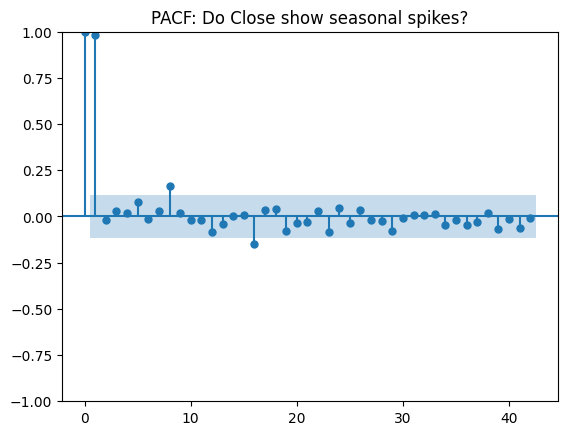

In [28]:
plot_pacf(time_df["Close"].dropna(), lags=42)
plt.title("PACF: Do Close show seasonal spikes?")
plt.show()

ACF of close shows gradual decay, series with trends; and no significant spikes at lag intervals in ACF and PACF confirm no seasonality in close price.

#### Check Log-Return lag structure and model order

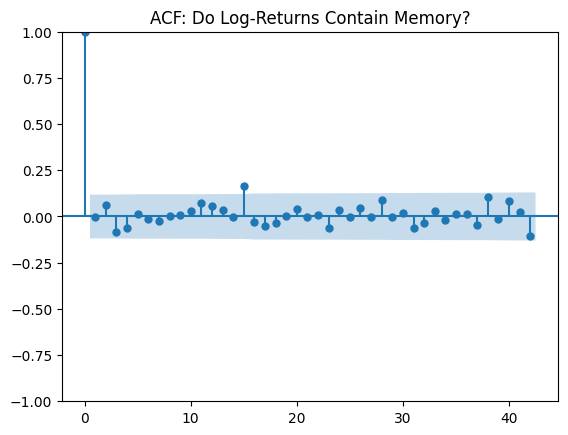

In [29]:
plot_acf(time_df["LogReturn"].dropna(), lags=42)
plt.title("ACF: Do Log-Returns Contain Memory?")
plt.show()

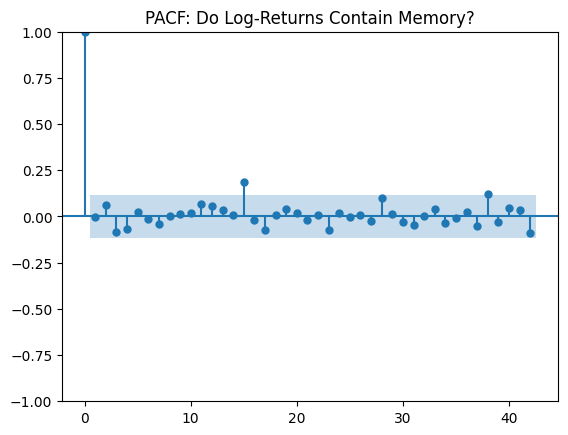

In [30]:
plot_pacf(time_df["LogReturn"].dropna(), lags=42)
plt.title("PACF: Do Log-Returns Contain Memory?")
plt.show()

ACF and PACF are mostly inside the confidence band, indicating the absence of trend, seasonality, or linear memory in the mean. The one spike at 15 log might be volatility, or just random behaviour, which seems fine for stock data.